In [10]:
import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from statsmodels.tsa.arima_model import ARIMA
import itertools

In [2]:
pwd()

'/Users/julia/Desktop'

In [11]:
import os
os.chdir('/Users/julia/Desktop/Thesis/Code Repository')

In [12]:
df = pd.read_csv('mapped.csv')

In [13]:
df['Project Number'] = df['Project Number'].astype('str') 
df['Fiscal Period Code'] = pd.to_datetime(df['Fiscal Period Code'], format='%Y%m') 

In [14]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [15]:
freq=df.groupby('Project Number')
count =freq['Project Number'].count()
df_count=pd.DataFrame({'Project Number':count.index, 'count':count.values})
df_count.sort_values('count', 
                      inplace=True, 
                      ascending=False)
df_count

,Project Number,count
81382,nan,1306653
6902,30004018,27
7248,30004364,27
7224,30004340,27
7221,30004337,27
...,...,...
41599,30082322,1
41598,30082321,1
41597,30082320,1
41596,30082319,1


In [16]:
df = pd.merge(df, df_count, on='Project Number')

In [17]:
df_27 = df[df['count'] == 27]

In [18]:
df_27.tail()

,Fiscal Period Code,Project Number,Project Id,Project Name,Health and Safety Status,project_date_create,Project Status,SalesCloudClientNo,Related Opportunity Project Number,Contract Type Name,...,interest_current,interest_jtd,interest_ytd,multiplier_budget,multiplier_current,multiplier_target,overhead_current,overhead_rate,revenue_type,count
1563836,2020-11-01,30017270,3.00001e+14,NJ000698.0011-PREPARATION OF CONSTRUCTION CO,Plan Not Required,NaN,Open/Active,NaN,NaN,Time and Material,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
1563837,2020-12-01,30017270,3.00001e+14,NJ000698.0011-PREPARATION OF CONSTRUCTION CO,Plan Not Required,NaN,Open/Active,NaN,NaN,Time and Material,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
1563838,2021-01-01,30017270,300000708267513,NJ000698.0011-PREPARATION OF CONSTRUCTION CO,Plan Not Required,NaN,Open/Active,NaN,NaN,Time and Material,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
1563839,2021-02-01,30017270,300000708267513,NJ000698.0011-PREPARATION OF CONSTRUCTION CO,Plan Not Required,NaN,Open/Active,NaN,NaN,Time and Material,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
1563840,2021-03-01,30017270,3.00001e+14,NJ000698.0011-PREPARATION OF CONSTRUCTION CO,Plan Not Required,NaN,Open/Active,NaN,NaN,Time and Material,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27


In [19]:
#Generate singel plot for Backlog given Project number
def revenue_analysis(project):
    df_project = df[df['Project Number'] == project]
    df_project = df_project[["Fiscal Period Code", "Funding Amount - ITC (Snapshot)", "Backlog NR", 'Actual Gross Revenue - ITD', 'Actual Gross Revenue - MTD','Actual Gross Revenue - YTD', 'Actual Net Revenue - ITD','Actual Net Revenue - MTD', 'Actual Net Revenue - YTD']].copy()
    df_project['Backlog_Shifted'] = df_project['Backlog NR'].transform(lambda x:x.shift())
    df_project.reset_index(inplace=True)
    df_project = df_project.loc[:, ~df_project.columns.str.contains('^index')]
    subset= df_project[['Fiscal Period Code', 'Actual Net Revenue - MTD']].copy()
    subset.plot(y ='Actual Net Revenue - MTD', x="Fiscal Period Code", kind="line")
    return pyplot.show()

In [20]:
#Generate dataframe based on project id
def obtain_df(project):
    df_project = df[df['Project Number'] == project]
    df_project = df_project[["Fiscal Period Code", "Funding Amount - ITC (Snapshot)", "Backlog NR", 'Actual Gross Revenue - ITD', 'Actual Gross Revenue - MTD','Actual Gross Revenue - YTD', 'Actual Net Revenue - ITD','Actual Net Revenue - MTD', 'Actual Net Revenue - YTD']].copy()
    df_project['Backlog_Shifted'] = df_project['Backlog NR'].transform(lambda x:x.shift())
    df_project.reset_index(inplace=True)
    df_project = df_project.loc[:, ~df_project.columns.str.contains('^index')]
    return df_project

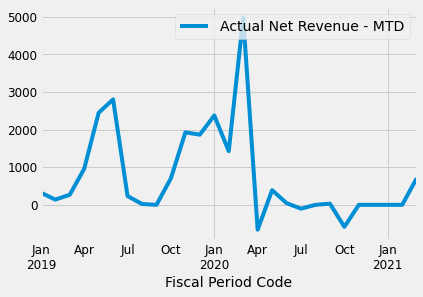

In [11]:
revenue_analysis('30004018') #30004340 #30004337

In [12]:
df_30004018 = obtain_df('30004018')

In [21]:
#Generate plot analysis 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

def decomposition_plot(project_number, name, sector):
    df_pn= df[df['Project Number'] == project_number]
    df_pn = df_pn[['Fiscal Period Code', 'Actual Net Revenue - MTD']].copy()
    df_pn = df_pn.set_index('Fiscal Period Code')
    decomposition = sm.tsa.seasonal_decompose(df_pn, model='additive')
    fig = decomposition.plot()
    return print(f" Selected Project Number: {project_number}"), print(f" Name: {name}"), print(f" Sector: {sector}"), plt.show()

In [22]:
#Extracting random samples from the dataframe with 27 observations
def random_project():
    df_x = df_27.sample(n=1)
    project_number = df_x['Project Number'].item()
    return project_number

In [15]:
random_project()

'30006744'

In [23]:
def random_project_analysis():
    df_x = df_27.sample(n=1)
    project_number = df_x['Project Number'].item()
    name = df_x['Project Name'].item()
    sector = df_x['Ultimate Customer AUS Market Sector'].item()
    return decomposition_plot(project_number, name, sector)

In [24]:
def selected_project_analysis(project):
    df_x = df_27[df_27['Project Number'] == project]
    name = df_x['Project Name'].iloc[-1]
    sector = df_x['Ultimate Customer AUS Market Sector'].iloc[-1]
    return decomposition_plot(project, name, sector)

 Selected Project Number: 30003773
 Name: B0095574.0006-GM - Englewood, NJ Phase IV ES
 Sector: Automotive


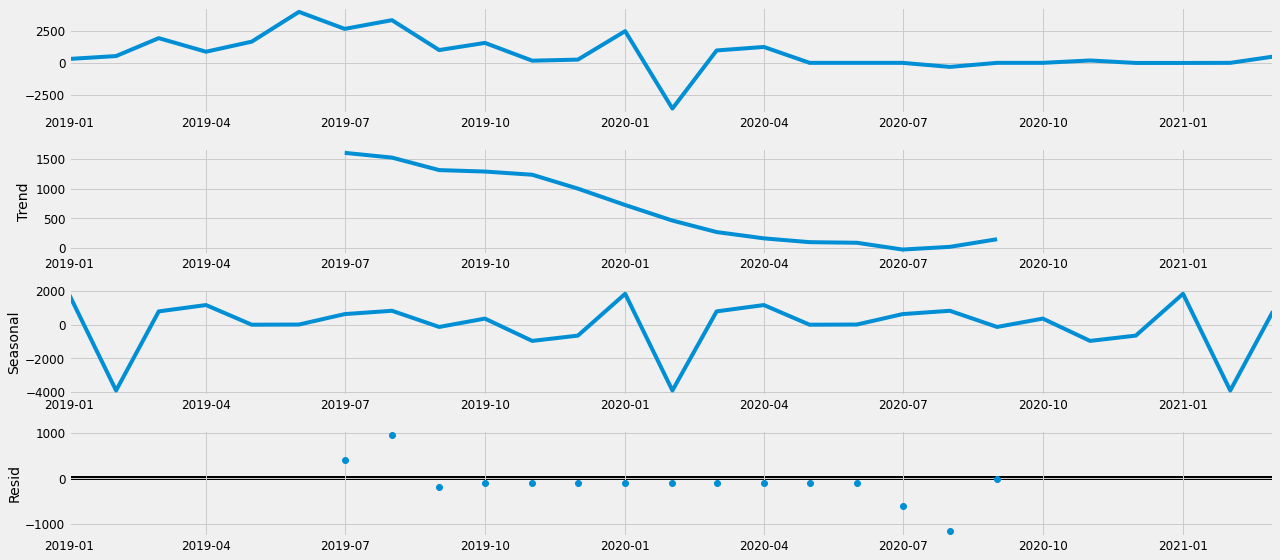

(None, None, None, None)

In [18]:
random_project_analysis()

 Selected Project Number: 30019035
 Name: WF0590GE.002A-UNIT 2A GENERAL SERVICES
 Sector: Municipalities/Local Govt.


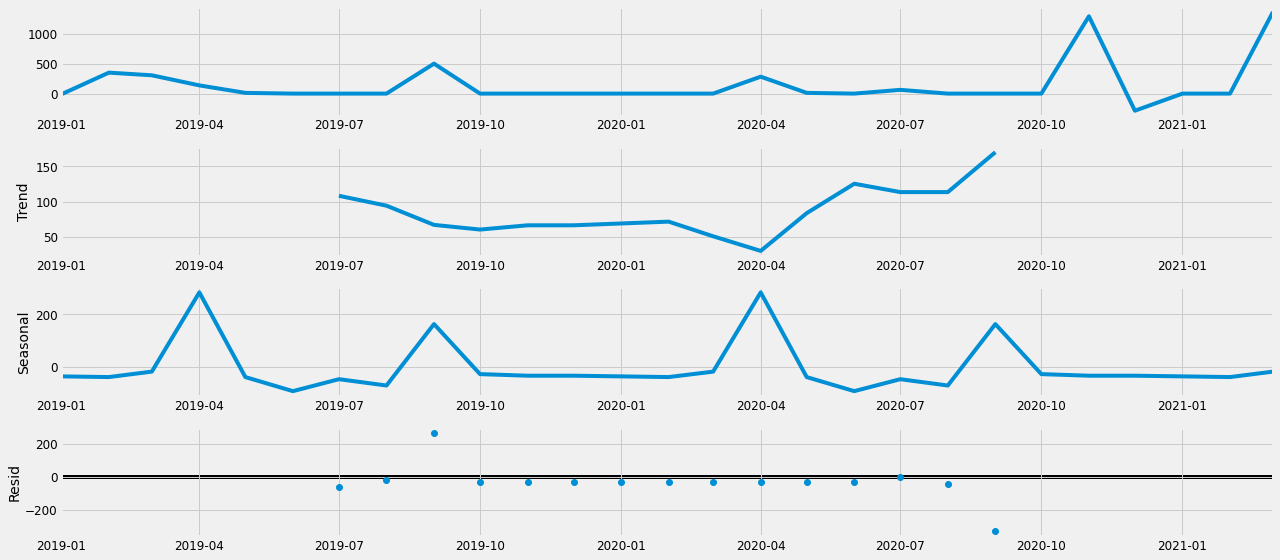

(None, None, None, None)

In [256]:
selected_project_analysis('30019035')

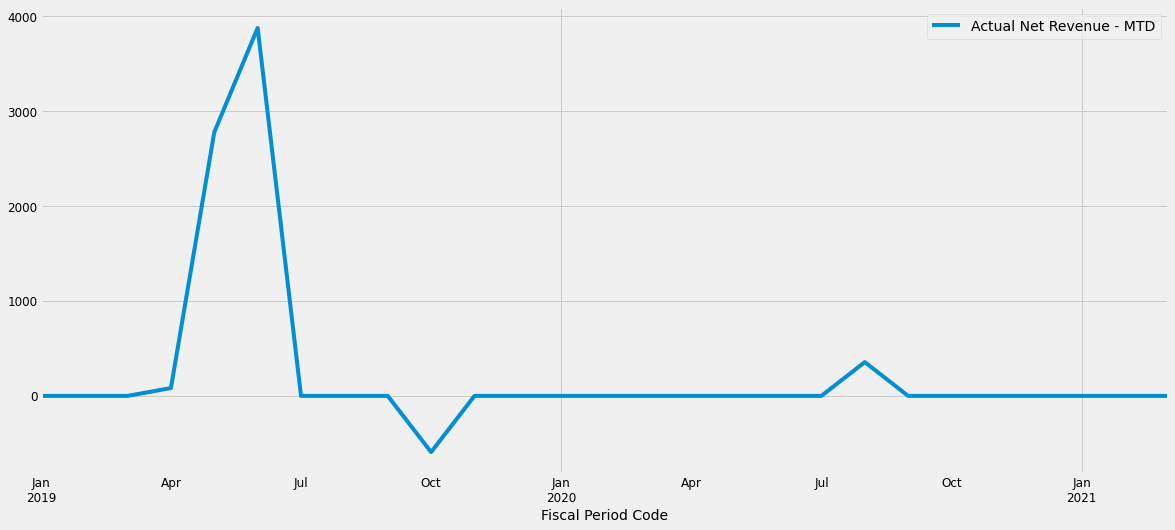

In [30]:
revenue_analysis('30005353')

### Time Series using SARIMAX
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data. Akaike information criterion can be used to evaluate the best parameters. p is the number of previous time steps that will be considered. There is a value called “q” in the moving average model that is the order. In SARIMAX, we even take into account the seasonality of the pattern

In [26]:
def obtain_timeseries(project):
    df_pn = obtain_df(project)
    df_pn = df_pn[['Fiscal Period Code', 'Actual Net Revenue - MTD']].copy()
    df_pn = df_pn.set_index('Fiscal Period Code')
    return df_pn

In [29]:
x=random_project()
x

'30019574'

In [31]:
some_df =obtain_timeseries('30003773') #'30013631' df_30013631

In [32]:
import statsmodels.api as sm
import itertools

# Grid Search
p = d = q = range(0,2) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 12 # here I use twelve but the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
aics = []
# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(some_df, order=combination, seasonal_order=seasonal_combination)
                                             #enforce_stationarity=False,
                                             #enforce_invertibility=False)
            model = model.fit()
            combs.update({model.aic : [combination, seasonal_combination]})
            aics.append(model.aic)
            
        except:
            continue
            
best_aic = min(aics)

# Modeling and forcasting
model = sm.tsa.statespace.SARIMAX(some_df, order=combs[best_aic][0], seasonal_order=combs[best_aic][1])
                                             #enforce_stationarity=False,
                                             #enforce_invertibility=False)
results = model.fit()
results.forecast(7)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9921      0.479     -2.071      0.038      -1.931      -0.053
ar.S.L12      -0.9656      0.109     -8.874      0.000      -1.179      -0.752
sigma2       1.43e+06   3.34e-07   4.28e+12      0.000    1.43e+06    1.43e+06


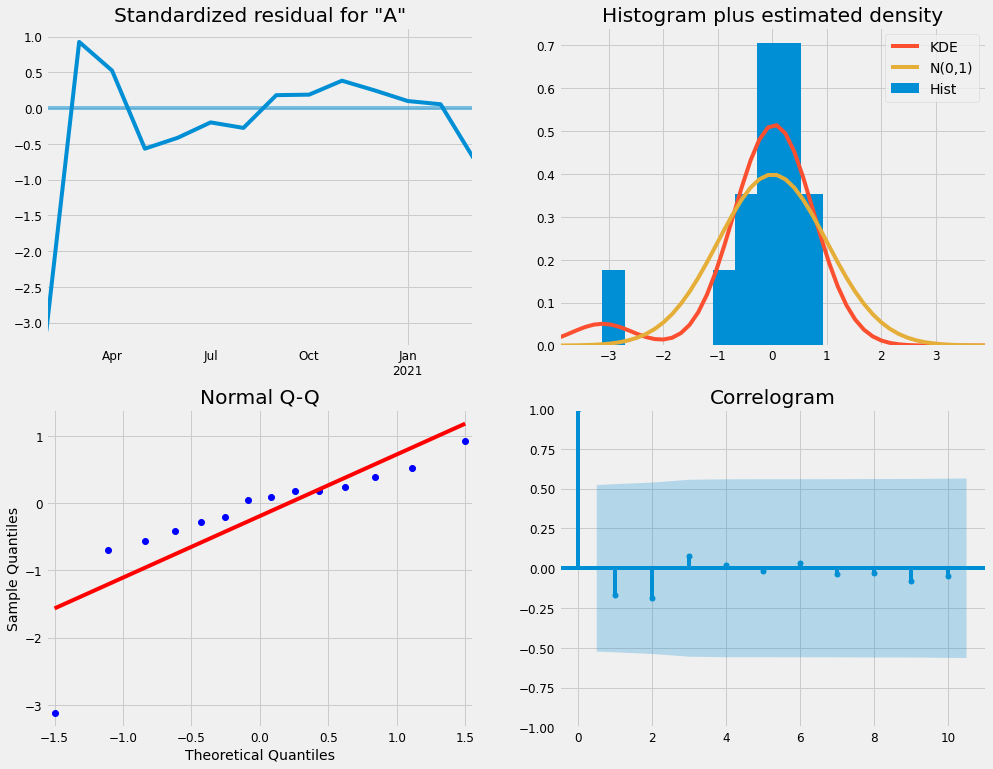

In [33]:
# if doesn't work, change 3 to 2
results.plot_diagnostics(figsize=(15, 12))
plt.show()

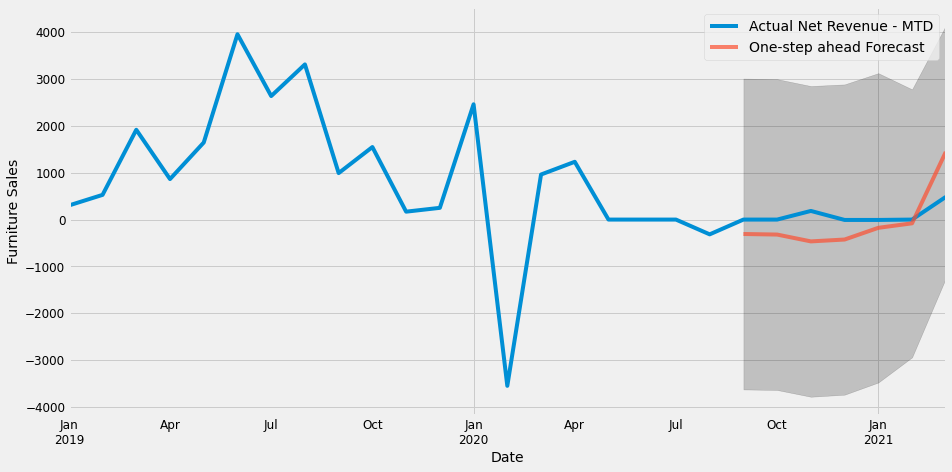

In [34]:
pred = results.get_prediction(start=pd.to_datetime('2020-09'), dynamic=False)
pred_ci = pred.conf_int()
ax = some_df['2019-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [35]:
y_forecasted = pred.predicted_mean
y_truth = some_df['2020-09':]
y_truth = pd.Series(y_truth['Actual Net Revenue - MTD'].values, index=y_truth.index)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 249779.48


### Root Mean squared Error 
can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. The model can forecast the sales within RMSE of the real test set, given the range of the test set

In [36]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 499.78


In [37]:
def performance_comparison(x):
    another_df = obtain_df(x)
    y_forecasted = pred.predicted_mean.to_frame()
    plt.figure(figsize=(20, 8))
    plt.plot(another_df['Fiscal Period Code'], another_df['Actual Net Revenue - MTD'], 'b-', label = 'Actual Revenue')
    plt.plot(another_df['Fiscal Period Code'], another_df['Backlog_Shifted'], 'r-', label = 'Backlog Forecast')
    plt.plot(y_forecasted.index, y_forecasted['predicted_mean'], 'g-', label = 'Prediction SARIMAX model')
    plt.xlabel('Date'); plt.ylabel('Revenue'); plt.title('Performance comparison')
    plt.legend();
    return plt.show()

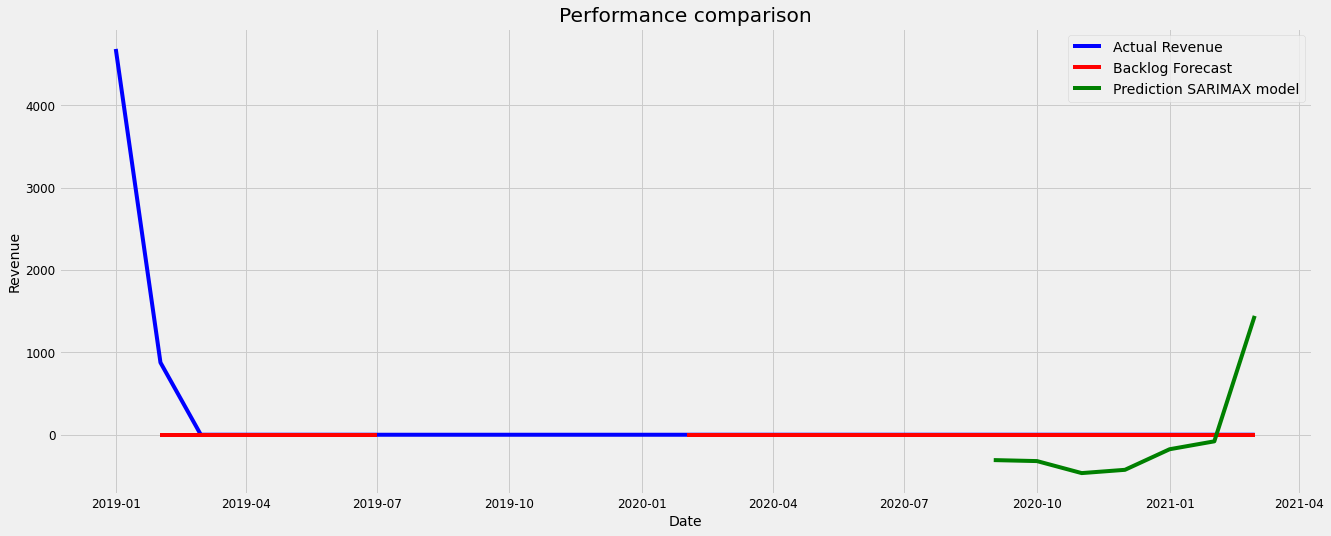

In [38]:
performance_comparison(x)

### Time Series using ARIMA
Befire we used a SARIMAX, but there is certainly no seasonality in each project

In [39]:
from statsmodels.tsa.arima_model import ARIMA
import itertools
# Grid Search
p = d = q = range(0,5) # p, d, and q between 0-4
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q
combs = {} # stores aic and order pairs
aics = [] # stores aics
# Grid Search continued
for combination in pdq:
    try:
        model = ARIMA(some_df, order=combination) # create all possible models
        model = model.fit()
        combs.update({model.aic : combination}) # store combinations
        aics.append(model.aic)
    except:
        continue
        
best_aic = min(aics)
# Model Creation and Forecasting
model = ARIMA(some_df, order=combs[best_aic])
model = model.fit()
pred = model.forecast(7)[0]
print(type(best_aic), type(combs[best_aic]))

<class 'float'> <class 'tuple'>


In [40]:
y_forecasted = pred
y_truth = some_df['2020-09':]
y_truth = pd.Series(y_truth['Actual Net Revenue - MTD'].values, index=y_truth.index)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 366875.93


In [41]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 605.7


In [42]:
def performance_comparison_arima(x):
    another_df = obtain_df(x)
    b=another_df.iloc[-7:,:1].values
    b= b.reshape(7,)
    df_forecast = pd.DataFrame({'Fiscal Period Code':b, 'Prediction': y_forecasted})
    plt.figure(figsize=(20, 8))
    plt.plot(another_df['Fiscal Period Code'], another_df['Actual Net Revenue - MTD'], 'b-', label = 'Actual Revenue')
    plt.plot(another_df['Fiscal Period Code'], another_df['Backlog_Shifted'], 'r-', label = 'Backlog Forecast')
    plt.plot(df_forecast['Fiscal Period Code'], df_forecast['Prediction'], 'g-', label = 'Prediction ARIMA Model')
    plt.xlabel('Date'); plt.ylabel('Revenue'); plt.title('Performance comparison')
    plt.legend();
    return plt.show()

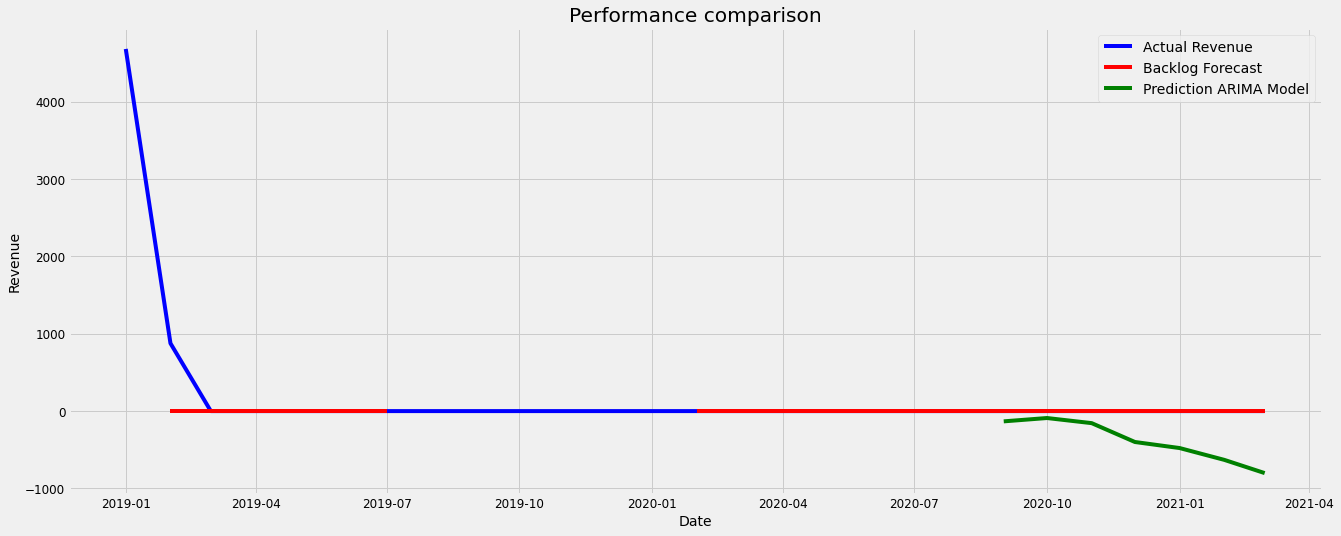

In [43]:
performance_comparison_arima(x)